In [22]:
import json 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from hypyp import stats 
import seaborn as sns
from statannot import add_stat_annotation

In [70]:
f = open('simple_results_alpha.json')

# returns JSON object as 
# a dictionary
results = json.load(f)
  
# Iterating through the json
# list
fp1_alpha = []
sf1_alpha = []
fp2_alpha = []
sf2_alpha = []
ru_alpha = []

all_stages = [fp1_alpha, sf1_alpha, fp2_alpha, sf2_alpha, ru_alpha]
for part, stages in results.items():
    if part == '623' or part == '802':
        continue
    else:
        for stage, data in stages.items():
            stage = int(stage[1]) - 1
            all_stages[stage].append(np.nanmean(data))

sf2_alpha = [0 if str(x) == 'nan' else x for x in sf2_alpha]

data_alpha = [np.array(fp1_alpha), np.array(sf1_alpha), np.array(fp2_alpha), np.array(sf2_alpha)] 

In [63]:
df_dict = {'freeplay1': fp1_alpha,
           'stillface1': sf1_alpha,
           'freeplay2': fp2_alpha,
           'sf2_alpha': sf2_alpha,
           'ru_alpha': ru_alpha}

df = pd.DataFrame(df_dict)
df.to_csv('plv_results_alpha.csv')
print(df)

    freeplay1  stillface1  freeplay2  sf2_alpha  ru_alpha
0    0.261570    0.257778   0.253058   0.259555  0.260883
1    0.251305    0.255803   0.252177   0.251335  0.251390
2    0.254150    0.242790   0.256775   0.247727  0.253671
3    0.255040    0.248866   0.240057   0.250856  0.249279
4    0.252914    0.250490   0.247936   0.254836  0.250149
5    0.248928    0.250089   0.252452   0.251736  0.251714
6    0.252442    0.230762   0.249311   0.226244  0.246853
7    0.250057    0.253792   0.250950   0.267791  0.247728
8    0.243366    0.208467   0.241274   0.224614  0.245123
9    0.258490    0.260590   0.258181   0.258135  0.257408
10   0.242606    0.239085   0.245430   0.235983  0.242270
11   0.252926    0.250148   0.255093   0.250467  0.249423
12   0.255242    0.255156   0.262488   0.249914  0.259533
13   0.255699    0.245243   0.254191   0.248934  0.252531
14   0.254909    0.253626   0.255287   0.253666  0.255202
15   0.253289    0.256428   0.248100   0.253695  0.252598
16   0.255424 

# Test Normality of Distribution

In [96]:
import pandas as pd
import pingouin as pg
from scipy.stats import shapiro

# Load data
df = pd.DataFrame({"FreePlay1": fp1_alpha,
                  "StillFace1": sf1_alpha,
                  "FreePlay2": fp2_alpha,
                  "StillFace2": sf2_alpha,
                #   'Reunion': ru_alpha
                  })


# Create a multi-indexed dataframe
df_melted_alpha = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2'])#, 'Reunion'])

# Rename columns
df_melted_alpha.columns = ['id', 'Condition', 'Synchrony']

# grouped = df_melted.groupby(["condition"])

data = np.random.normal(0, 1, 100)
stat, p = shapiro(df_melted_alpha["Synchrony"])

print("Test statistic:", stat)
print("p-value:", p)

Test statistic: 0.9038286209106445
p-value: 1.0375048731248171e-07


# Fisher Z Transform

In [95]:
# Perform the Fisher z-transform
z_fp1_alpha = np.arctanh(fp1_alpha)
z_sf1_alpha = np.arctanh(sf1_alpha)
z_fp2_alpha = np.arctanh(fp2_alpha)
z_sf2_alpha = np.arctanh(sf2_alpha)
z_ru_alpha = np.arctanh(ru_alpha)

# Load data
df = pd.DataFrame({"FreePlay1": z_fp1_alpha,
                  "StillFace1": z_sf1_alpha,
                  "FreePlay2": z_fp2_alpha,
                  "StillFace2": z_sf2_alpha,
                  'Reunion': z_ru_alpha
                  })


# Create a multi-indexed dataframe
df_melted_z = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_z.columns = ['id', 'Condition', 'Synchrony']

data = np.random.normal(0, 1, 100)
stat, p = shapiro(df_melted_z["Synchrony"])

print("Test statistic:", stat)
print("p-value:", p)

Test statistic: 0.9064258337020874
p-value: 1.4422651872791903e-07


### The distribution is still not normal -> non-parametric one-way ANOVA -> Friedman Test

## Friedman Test
The null hypothesis (H0): The mean for each population is equal.

The alternative hypothesis: (Ha): At least one population mean is different from the rest.

https://www.statology.org/friedman-test-python/

In [97]:
# Perform Friedman test
pg.friedman(data=df_melted_alpha, dv='Synchrony', within='Condition', subject = 'id')

,Source,W,ddof1,Q,p-unc
Friedman,Condition,0.113315,3,11.218182,0.010603


In [98]:
import scikit_posthocs as sp
post_hoc_wilcoxon_alpha = sp.posthoc_wilcoxon(a = df_melted_alpha, val_col = "Synchrony", group_col = "Condition", p_adjust = 'bonferroni')
post_hoc_wilcoxon_alpha

,FreePlay1,StillFace1,FreePlay2,StillFace2
FreePlay1,1.000000,0.055819,1.000000,0.003341
StillFace1,0.055819,1.000000,0.581718,1.000000
FreePlay2,1.000000,0.581718,1.000000,0.303514
StillFace2,0.003341,1.000000,0.303514,1.000000


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
FreePlay1 v.s. StillFace1: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.721e-02 stat=1.370e+02
Using zero_method  wilcox
StillFace1 v.s. FreePlay2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.878e-01 stat=1.870e+02
Using zero_method  wilcox
FreePlay2 v.s. StillFace2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.023e-01 stat=1.710e+02
Using zero_method  wilcox
FreePlay1 v.s. StillFace2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.227e-03 stat=9.500e+01


(<AxesSubplot: xlabel='Condition', ylabel='Synchrony'>,
  <statannot.StatResult.StatResult at 0x7fe8cc702a40>])

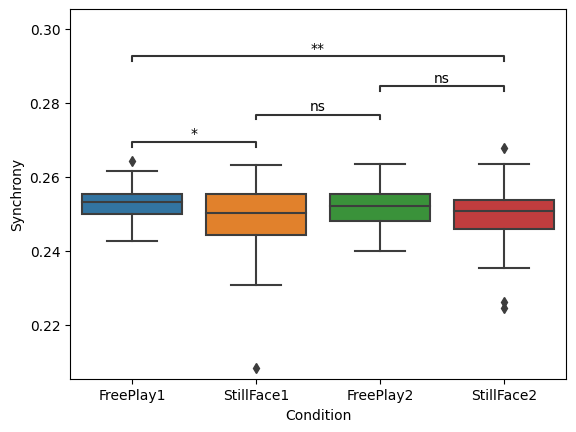

In [100]:
ax = sns.boxplot(data = df_melted_alpha, x = 'Condition', y = 'Synchrony')
# ax.set(ylim=(0.3, 0.55))
add_stat_annotation(ax, data = df_melted_alpha, x = 'Condition', y = 'Synchrony', 
                    box_pairs = [('FreePlay1', 'StillFace1'), ('FreePlay1', 'StillFace2'),  ('StillFace1', 'FreePlay2'), ('FreePlay2', 'StillFace2')],
                                 #('StillFace1', 'Reunion'), ('StillFace2', 'Reunion')],
                    perform_stat_test=True,
                    test = 'Wilcoxon',
                    text_format = 'star',
)

In [101]:
from scipy.stats import wilcoxon
res = wilcoxon(fp1_alpha + fp2_alpha, sf1_alpha + sf2_alpha)
print("Wilcoxon Rank-Sum Test")
print(f"Statistic: {res.statistic}, p-value: {res.pvalue}")

Wilcoxon Rank-Sum Test
Statistic: 601.0, p-value: 0.0012694992107459154


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

FreePlay v.s. StillFace: Custom statistical test, P_val:1.269e-03


(<AxesSubplot: xlabel='Condition', ylabel='Synchrony'>,
 [<statannot.StatResult.StatResult at 0x7fe8cc6dc7c0>])

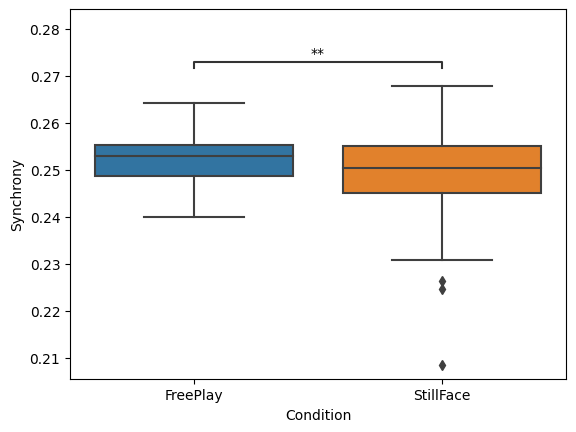

In [103]:
from scipy.stats import wilcoxon
import seaborn as sns
from statannot import add_stat_annotation

df1 = pd.DataFrame({"FreePlay": fp1_alpha + fp2_alpha,
                  "StillFace": sf1_alpha + sf2_alpha
                  })


# Create a multi-indexed dataframe
df_melted_t = pd.melt(df1.reset_index(), id_vars=['index'], value_vars=['FreePlay', 'StillFace'])

# Rename columns
df_melted_t.columns = ['id', 'Condition', 'Synchrony']

ax = sns.boxplot(data = df_melted_t, x = 'Condition', y = 'Synchrony')
# ax.set(ylim=(0.3, 0.55))
add_stat_annotation(ax, data = df_melted_t, x = 'Condition', y = 'Synchrony', 
                    box_pairs = [('FreePlay', 'StillFace')],
                    perform_stat_test=False,
                    text_format = 'star',
                    pvalues = [0.0012694992107459154]
                    )

# Theta

In [80]:
f = open('simple_results_theta.json')

# returns JSON object as 
# a dictionary
results = json.load(f)
  
# Iterating through the json
# list
fp1_theta = []
sf1_theta = []
fp2_theta = []
sf2_theta = []
ru_theta = []

all_stages = [fp1_theta, sf1_theta, fp2_theta, sf2_theta, ru_theta]
for part, stages in results.items():
    if part == '802' or part == '623':
        continue
    else:
        for stage, data in stages.items():
            stage = int(stage[1]) - 1
            all_stages[stage].append(np.nanmean(data))

sf2_theta = [0 if str(x) == 'nan' else x for x in sf2_theta]

data_theta = [fp1_theta, sf1_theta, fp2_theta, sf2_theta, ru_theta] 
data_theta = [np.array(x) for x in data_theta]

f.close()

In [91]:
import pandas as pd
import pingouin as pg
from statsmodels.stats.anova import AnovaRM
from scipy.stats import shapiro

# Load data
df = pd.DataFrame({"FreePlay1": fp1_theta,
                  "StillFace1": sf1_theta,
                  "FreePlay2": fp2_theta,
                  "StillFace2": sf2_theta,
                #   'Reunion': ru_theta
                  })


# Create a multi-indexed dataframe
df_melted_theta = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2'])#, 'Reunion'])

# Rename columns
df_melted_theta.columns = ['id', 'Condition', 'Synchrony']

stat, p = shapiro(df_melted_theta["Synchrony"])

print("Test statistic:", stat)
print("p-value:", p)

Test statistic: 0.969528317451477
p-value: 0.004602065775543451


In [92]:
# Perform Friedman test
pg.friedman(data=df_melted_theta, dv='Synchrony', within='Condition', subject = 'id')

,Source,W,ddof1,Q,p-unc
Friedman,Condition,0.300643,3,29.763636,0.000002


In [93]:
post_hoc_wilcoxon_theta = sp.posthoc_wilcoxon(a = df_melted_theta, val_col = "Synchrony", group_col = "Condition", p_adjust = 'bonferroni')
post_hoc_wilcoxon_theta

,FreePlay1,StillFace1,FreePlay2,StillFace2
FreePlay1,1.000000,0.000048,1.000000,0.027364
StillFace1,0.000048,1.000000,0.000034,1.000000
FreePlay2,1.000000,0.000034,1.000000,0.003087
StillFace2,0.027364,1.000000,0.003087,1.000000


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
FreePlay1 v.s. StillFace1: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.230e-05 stat=5.100e+01
Using zero_method  wilcox
StillFace1 v.s. FreePlay2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.252e-05 stat=4.800e+01
Using zero_method  wilcox
FreePlay2 v.s. StillFace2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.058e-03 stat=9.400e+01
Using zero_method  wilcox
FreePlay1 v.s. StillFace2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.824e-02 stat=1.250e+02


(<AxesSubplot: xlabel='Condition', ylabel='Synchrony'>,
  <statannot.StatResult.StatResult at 0x7fe8cca71570>])

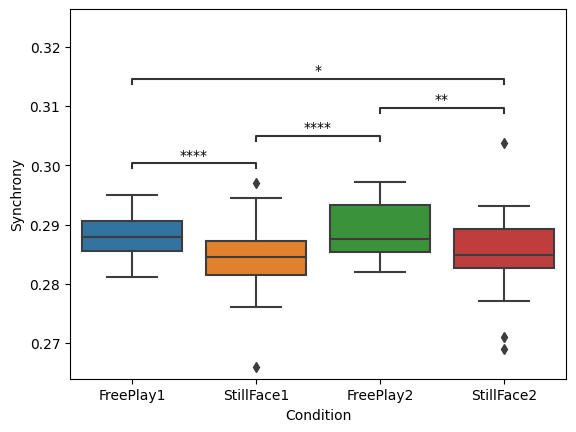

In [94]:
ax = sns.boxplot(data = df_melted_theta, x = 'Condition', y = 'Synchrony')
# ax.set(ylim=(0.3, 0.55))
add_stat_annotation(ax, data = df_melted_theta, x = 'Condition', y = 'Synchrony', 
                    box_pairs = [('FreePlay1', 'StillFace1'), ('FreePlay1', 'StillFace2'),  ('StillFace1', 'FreePlay2'), ('FreePlay2', 'StillFace2'),
                                 ],
                    perform_stat_test=True,
                    test = 'Wilcoxon',
                    text_format = 'star',
)

Wilcoxon Rank-Sum Test
Statistic: 286.0, p-value: 1.6783231548498652e-07
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

FreePlay v.s. StillFace: Custom statistical test, P_val:1.678e-07


(<AxesSubplot: xlabel='Condition', ylabel='Synchrony'>,
 [<statannot.StatResult.StatResult at 0x7fe8cc4c64a0>])

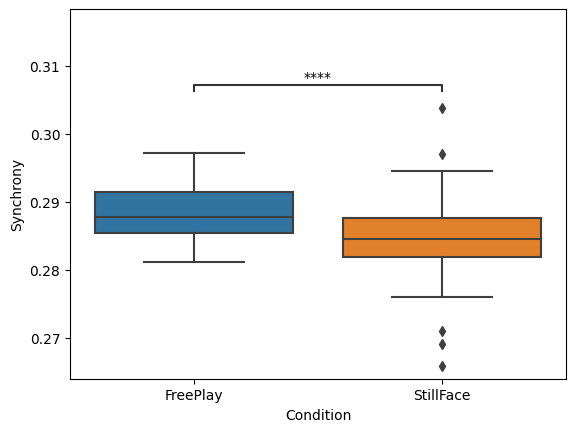

In [105]:
from scipy.stats import wilcoxon
import seaborn as sns
from statannot import add_stat_annotation

df1 = pd.DataFrame({"FreePlay": fp1_theta + fp2_theta,
                  "StillFace": sf1_theta + sf2_theta
                  })


# Create a multi-indexed dataframe
df_melted_t = pd.melt(df1.reset_index(), id_vars=['index'], value_vars=['FreePlay', 'StillFace'])

# Rename columns
df_melted_t.columns = ['id', 'Condition', 'Synchrony']

res = wilcoxon(fp1_theta + fp2_theta, sf1_theta + sf2_theta, correction = True)
print("Wilcoxon Rank-Sum Test")
print(f"Statistic: {res.statistic}, p-value: {res.pvalue}")

ax = sns.boxplot(data = df_melted_t, x = 'Condition', y = 'Synchrony')
# ax.set(ylim=(0.3, 0.55))
add_stat_annotation(ax, data = df_melted_t, x = 'Condition', y = 'Synchrony', 
                    box_pairs = [('FreePlay', 'StillFace')],
                    perform_stat_test=False,
                    text_format = 'star',
                    pvalues = [1.6783231548498652e-07]
                    )